## Neural Network Model

In [1]:
#import libraries 
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
#read in data
# read in data
parcel_data=pd.read_csv('data/join_scag_to_parcels_left_2019.csv')

# data clean-up
# use lambda functions to denote whether warehouse had been built on each parcel by 2010 and by 2020 (fixing error in previous version)
parcel_data['warehouse_2010']=parcel_data.year.apply(lambda x: 1 if x<2010 else 0)
parcel_data['warehouse_2020']=parcel_data.year.apply(lambda x: 1 if x<2020 else 0)
parcel_data['built_2010s']=parcel_data.year.apply(lambda x: 1 if (2010 <= x < 2020) else 0)

# replace county names w/ dummies
dummies=pd.get_dummies(parcel_data.COUNTY, prefix='county')
parcel_data = parcel_data.join(dummies)
parcel_data.head()

C:\Users\cpugh\AppData\Local\Temp\ipykernel_29452\422570143.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  parcel_data=pd.read_csv('data/join_scag_to_parcels_left_2019.csv')


,APN,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_2010,warehouse_2020,...,Specific Plan,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water,dollars_per_acre,county_Riverside,county_San Bernardino
0,933260003.0,48418.0,38449.033944,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2406.435207,1,0
1,933190003.0,210496.0,39355.337470,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10667.570219,1,0
2,933200001.0,347975.0,39133.409768,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17690.981870,1,0
3,933180027.0,88468.0,39830.303362,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9505.916138,1,0
4,933180028.0,334555.0,38830.371787,NaN,NaN,NaN,NaN,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16032.116147,1,0


In [3]:
# copy dataset and delete/rename variables as needed
parceldata_10=parcel_data.copy()
parceldata_10.drop(columns=['warehouse_2020'],inplace=True)
parceldata_10.rename(columns={'warehouse_2010':'warehouse_start','built_2010s':'buit_within_decade'},inplace=True)

# need to set APN to be index so that we can join this back to other information later on
parceldata_10.set_index('APN',inplace=True)

In [4]:
#parceldata_10.columns.tolist()

## Standardize Data

In [5]:
#standardize data

otherCols = ['LAND_VALUE',
 'distances',
 'acres',
 'sqft',
 'num_warehouses',
 'ACRES',
 'IL_RATIO',
 'dollars_per_acre']

cols_to_exclude  = [col for col in parceldata_10.columns if col not in otherCols]
cols_to_exclude 

['building_class',
 'year',
 'warehouse_start',
 'buit_within_decade',
 'lon',
 'lat',
 'geometry',
 'PID19',
 'APN19',
 'COUNTY',
 'CITY',
 'LU19',
 'LU16',
 'JURISDICTI',
 'LU19_CLASS',
 'SCAG_ZN_CO',
 'Shape_Leng',
 'Shape_Area',
 'Agriculture',
 'Commercial and Services',
 'Education',
 'Facilities',
 'General Office',
 'Industrial',
 'Military Installations',
 'Mixed Commercial and Industrial',
 'Mixed Residential',
 'Mixed Residential and Commercial',
 'Mobile Homes and Trailer Parks',
 'Multi-Family Residential',
 'None',
 'Open Space and Recreation',
 'Rural Residential',
 'Single Family Residential',
 'Specific Plan',
 'Transportation, Communications, and Utilities',
 'Under Construction',
 'Undevelopable',
 'Unknown',
 'Vacant',
 'Water',
 'county_Riverside',
 'county_San Bernardino']

In [6]:
parceldata_10[otherCols].info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1367392 entries, 933260003.0 to 42316138.0
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   LAND_VALUE        1367392 non-null  float64
 1   distances         1367392 non-null  float64
 2   acres             3335 non-null     float64
 3   sqft              3335 non-null     float64
 4   num_warehouses    1367392 non-null  float64
 5   ACRES             1367392 non-null  float64
 6   IL_RATIO          1367392 non-null  float64
 7   dollars_per_acre  1367392 non-null  float64
dtypes: float64(8)
memory usage: 93.9 MB


In [7]:
#scale "otherCols"
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(parceldata_10[otherCols])

# convert to DataFrame and specify the column names and index
df_scaled = pd.DataFrame(scaler.transform(parceldata_10[otherCols]), 
                         columns=otherCols, index=parceldata_10.index)

# create a DataFrame with these scaled columns joined to the columns that we didn't scale
df_scaled = df_scaled.join(parceldata_10[cols_to_exclude])

df_scaled.head()

,LAND_VALUE,distances,acres,sqft,num_warehouses,ACRES,IL_RATIO,dollars_per_acre,building_class,year,...,Single Family Residential,Specific Plan,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water,county_Riverside,county_San Bernardino
APN,,,,,,,,,,,,,,,,,,,,,
933260003.0,-0.101648,0.656476,NaN,NaN,-0.048998,0.542520,-0.211640,-0.576212,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
933190003.0,0.148459,0.689720,NaN,NaN,-0.048998,0.530209,-0.248570,-0.565727,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
933200001.0,0.360607,0.681580,NaN,NaN,-0.048998,0.528219,-0.248570,-0.556812,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
933180027.0,-0.039846,0.707143,NaN,NaN,-0.048998,0.199320,-0.248570,-0.567201,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
933180028.0,0.339898,0.670464,NaN,NaN,-0.048998,0.566246,-0.188108,-0.558917,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [8]:


# define variables 
cols=df_scaled.columns.to_list()
xvars=[col for col in cols if col not in ('lon', 'lat','county_Riverside','county_San Bernardino', 'APN','building_class','year','acres','sqft','num_warehouses','buit_within_decade',
                                          'geometry','PID19','APN19','CITY','COUNTY','LU19','LU16','JURISDICTI','LU19_CLASS','SCAG_ZN_CO','Shape_Leng','Shape_Area')]
yvar = 'buit_within_decade'

# create a dataframe with no NaNs
parceldata_10_model = df_scaled[xvars+[yvar]].dropna()

# create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    parceldata_10_model[xvars], parceldata_10_model[yvar], test_size = 0.25, random_state = 1)

In [9]:
xvars

['LAND_VALUE',
 'distances',
 'ACRES',
 'IL_RATIO',
 'dollars_per_acre',
 'warehouse_start',
 'Agriculture',
 'Commercial and Services',
 'Education',
 'Facilities',
 'General Office',
 'Industrial',
 'Military Installations',
 'Mixed Commercial and Industrial',
 'Mixed Residential',
 'Mixed Residential and Commercial',
 'Mobile Homes and Trailer Parks',
 'Multi-Family Residential',
 'None',
 'Open Space and Recreation',
 'Rural Residential',
 'Single Family Residential',
 'Specific Plan',
 'Transportation, Communications, and Utilities',
 'Under Construction',
 'Undevelopable',
 'Unknown',
 'Vacant',
 'Water']

In [10]:
#predict
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [11]:
# stop if the length of the predictions doesn't match the training dataset
assert len(X_test)==len(y_pred)

In [12]:
#check how it did
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    341730
           1       0.75      0.35      0.47       118

    accuracy                           1.00    341848
   macro avg       0.87      0.67      0.74    341848
weighted avg       1.00      1.00      1.00    341848



In [13]:
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

Predicted fraction True: 0.0002. Actual fraction True: 0.0003


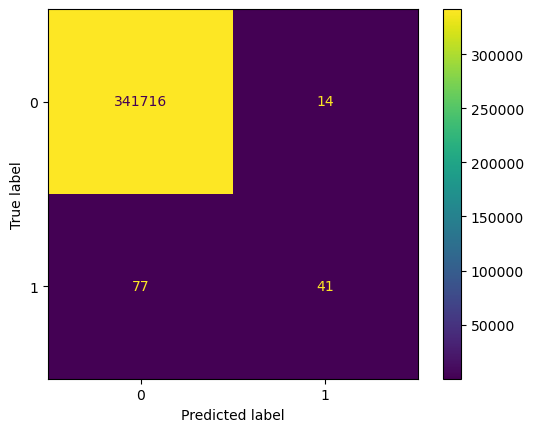

In [14]:
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.savefig('confusion_matrix_Neuralnet.png', dpi=300, bbox_inches='tight')

### Apply Model to 2020 Dataset

In [15]:
# Create a dataset for data as of 2020
parceldata_20=parcel_data.copy()
parceldata_20.drop(columns=['warehouse_2010'],inplace=True)
parceldata_20.rename(columns={'warehouse_2020':'warehouse_start','built_2010s':'buit_within_decade'},inplace=True)

# need to set APN to be index so that we can join this back to other information later on
parceldata_20.set_index('APN',inplace=True)

### Standardize New Dataframe

In [16]:
#select columns to standardize

otherCols = ['LAND_VALUE',
 'distances',
 'acres',
 'sqft',
 'num_warehouses',
 'ACRES',
 'IL_RATIO',
 'dollars_per_acre']

cols_to_exclude  = [col for col in parceldata_20.columns if col not in otherCols]

In [17]:
#scale "otherCols"
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(parceldata_20[otherCols])

# convert to DataFrame and specify the column names and index
df_scaled2 = pd.DataFrame(scaler.transform(parceldata_20[otherCols]), 
                         columns=otherCols, index=parceldata_20.index)

# create a DataFrame with these scaled columns joined to the columns that we didn't scale
df_scaled2 = df_scaled2.join(parceldata_20[cols_to_exclude])

df_scaled2.head()

,LAND_VALUE,distances,acres,sqft,num_warehouses,ACRES,IL_RATIO,dollars_per_acre,building_class,year,...,Single Family Residential,Specific Plan,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water,county_Riverside,county_San Bernardino
APN,,,,,,,,,,,,,,,,,,,,,
933260003.0,-0.101648,0.656476,NaN,NaN,-0.048998,0.542520,-0.211640,-0.576212,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
933190003.0,0.148459,0.689720,NaN,NaN,-0.048998,0.530209,-0.248570,-0.565727,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
933200001.0,0.360607,0.681580,NaN,NaN,-0.048998,0.528219,-0.248570,-0.556812,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
933180027.0,-0.039846,0.707143,NaN,NaN,-0.048998,0.199320,-0.248570,-0.567201,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
933180028.0,0.339898,0.670464,NaN,NaN,-0.048998,0.566246,-0.188108,-0.558917,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [18]:
# define variables 
cols=df_scaled2.columns.to_list()
xvars=[col for col in cols if col not in ('lon', 'lat','county_Riverside','county_San Bernardino', 'APN','building_class','year','acres','sqft','num_warehouses','buit_within_decade',
                                          'geometry','PID19','APN19','CITY','COUNTY','LU19','LU16','JURISDICTI','LU19_CLASS','SCAG_ZN_CO','Shape_Leng','Shape_Area')]
yvar = 'buit_within_decade'

# create a dataframe with no NaNs
parceldata_20_model = df_scaled2[xvars+[yvar]].dropna()

In [19]:
# apply predictions from previous model to test dataset
X_test=parceldata_20_model[xvars]
y_pred = mlp.predict(X_test)

In [20]:
# stop if lengths don't match
assert len(X_test)==len(y_pred)
# how many does it predict?
print('Predicted fraction True: {:.4f}'.format(y_pred.mean()))
print('Predicted number True: {:.0f}'.format(y_pred.sum()))

Predicted fraction True: 0.0000
Predicted number True: 57


In [21]:
# create a dataframe of predictions about whether or not a parcel will have a warehouse built on it within 10 years & join this to the full df
predictions = pd.DataFrame(mlp.predict_proba(X_test),columns = ['pred_noWH', 'pred_WH'])
predictions= predictions.join((X_test).reset_index())
predictions.set_index('APN',inplace=True)
predictions.head()

,pred_noWH,pred_WH,LAND_VALUE,distances,ACRES,IL_RATIO,dollars_per_acre,warehouse_start,Agriculture,Commercial and Services,...,Open Space and Recreation,Rural Residential,Single Family Residential,Specific Plan,"Transportation, Communications, and Utilities",Under Construction,Undevelopable,Unknown,Vacant,Water
APN,,,,,,,,,,,,,,,,,,,,,
933260003.0,0.999988,0.000012,-0.101648,0.656476,0.542520,-0.211640,-0.576212,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933190003.0,0.999914,0.000086,0.148459,0.689720,0.530209,-0.248570,-0.565727,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
933200001.0,0.999843,0.000157,0.360607,0.681580,0.528219,-0.248570,-0.556812,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
933180027.0,0.999950,0.000050,-0.039846,0.707143,0.199320,-0.248570,-0.567201,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
933180028.0,0.999984,0.000016,0.339898,0.670464,0.566246,-0.188108,-0.558917,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
predictions.to_csv('predictions_neuralnet1.csv')